# Large scale text analysis with deep learning (3 points)

In this assignment, you will develop a deep learning model to predict salaries based on resumes (credits to to [Oleg Vasilev](https://github.com/Omrigan/)). While we will begin this project during our seminar class, it will require additional effort on your part to finalize and submit it as homework.

Following this, there is a supplementary task in another notebook titled homework_part2.ipynb. In this task, you are expected to conduct a more extensive study. This will involve testing various architectures to optimize prediction accuracy.

To secure full marks for this assignment, ensure a consistent training process with an MSE loss falling below 0.10. If necessary, feel free to experiment with different parameters and model architectures. If you achieve the desired results in the homework_part2.ipynb, you can either replicate your solution here or reference it explicitly in the comments when you submit.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from
1) Yandex-disk [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7), or
2) the Kaggle ompetition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [ ]:
# path_to_data = 'drive/MyDrive/Colab Notebooks/YandexNLP/Lecture2_Text_Classification/Train_rev1.csv'
path_to_data = 'drive/MyDrive/Colab Notebooks/YandexNLP/Lecture2_Text_Classification/Train_rev1.zip'

In [ ]:
# data = pd.read_csv(path_to_data, index_col=None)
data = pd.read_csv(path_to_data, compression='zip', index_col=None)
data.shape

(244768, 12)

In [ ]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

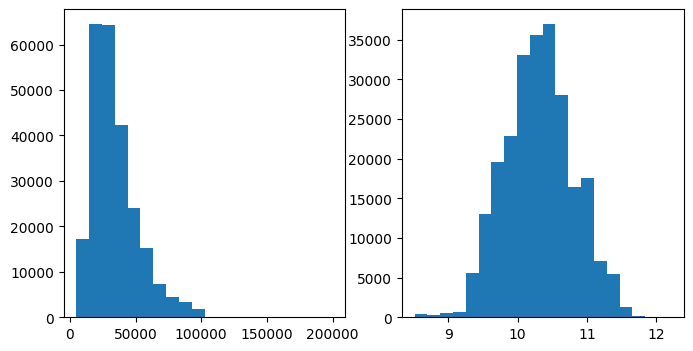

In [ ]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [ ]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
203210,71904292,Embedded Software Engineer (C / C++ Misra),A Staffordshire based organisation is looking ...,Stoke on Trent,Stoke-On-Trent,NaN,permanent,JAM Recruitment Ltd,Engineering Jobs,35k - 40k pa + Pension Bonus,37500,justengineers.net,10.532123
200294,71853144,Head of Finance Shared Service,Responsibility for preparing the Statutory Fi...,Reading Berkshire South East,Reading,NaN,permanent,Michael Page Finance,Other/General Jobs,70000 to 75000 per annum,72500,totaljobs.com,11.191356
48168,68592051,Senior Mechanical Design Engineer,Senior Mechanical Design Engineer (Design of S...,Loughborough Leicestershire England,Loughborough,NaN,NaN,ATA Recruitment,Creative & Design Jobs,GBP40k - 50k per year,45000,gojobsearch.co.uk,10.714440


In [ ]:
data0 = data.copy()

### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [ ]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [ ]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()

In [ ]:
data['Title'] = data['Title'].fillna('NaN')
print(data['Title'].value_counts())
print(data['Title'].isna().sum())

Title
Business Development Manager                                       921
Project Manager                                                    749
Management Accountant                                              661
Sales Executive                                                    603
Account Manager                                                    540
                                                                  ... 
Job Family Recruiter                                                 1
Leasehold Officer  Housing Services [Standard DBS/CRB required]      1
Sales/Retail Consultant                                              1
Science Teacher Required for Bolton area ASAP                        1
TEACHER OF ENGLISH                                                   1
Name: count, Length: 135436, dtype: int64
0


In [ ]:
print(data["FullDescription"].iloc[:5])
print(data["FullDescription"].iloc[:5].apply(lambda x: ' '.join(tokenizer.tokenize(x)).lower()))

data["FullDescription"] = data["FullDescription"].apply(lambda x: ' '.join(tokenizer.tokenize(x)).lower())
data["Title"] = data["Title"].apply(lambda x: ' '.join(tokenizer.tokenize(x)).lower())

0    Engineering Systems Analyst Dorking Surrey Sal...
1    Stress Engineer Glasgow Salary **** to **** We...
2    Mathematical Modeller / Simulation Analyst / O...
3    Engineering Systems Analyst / Mathematical Mod...
4    Pioneer, Miser  Engineering Systems Analyst Do...
Name: FullDescription, dtype: object
0    engineering systems analyst dorking surrey sal...
1    stress engineer glasgow salary **** to **** we...
2    mathematical modeller / simulation analyst / o...
3    engineering systems analyst / mathematical mod...
4    pioneer , miser engineering systems analyst do...
Name: FullDescription, dtype: object


Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
token_counts = Counter(' '.join(pd.concat([data["Title"], data['FullDescription']])).split())

In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


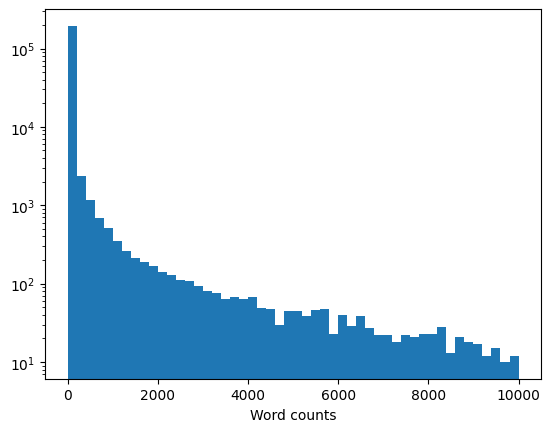

In [ ]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [ ]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [ ]:
tokens

['UNK',
 'PAD',
 '"',
 '$',
 '$****',
 '$****$****',
 '$****;',
 '%',
 '%)',
 '%),',
 '%).',
 '%****',
 '%,',
 '%.',
 '%/',
 '%;',
 '&',
 '&****',
 '&/',
 "'",
 "'&",
 "''",
 "')",
 "').",
 "'****",
 "'****'",
 "',",
 "'.",
 "';",
 "'>",
 "'>****",
 "'>•",
 "'?",
 '(',
 '($****',
 '(%',
 '(&',
 "('",
 '((',
 '()',
 '().',
 '(****',
 '(****%)',
 '(****)',
 '(****)(',
 '(****)****',
 '(****),',
 '(****).',
 '(********',
 '(********)',
 '(****/',
 '(****/****',
 '(****/****)',
 '(****/****),',
 '(****/****/****)',
 '(****:',
 '(****:****',
 '(****:****)',
 '(****:****:****)',
 '(.',
 '(>',
 '(>****',
 '(?)',
 '(‘',
 '(“',
 ')',
 ')&',
 ")'",
 ')(',
 '))',
 ')).',
 ')****',
 '),',
 ').',
 ').•',
 ')/',
 '):',
 ');',
 ')>',
 ')?',
 ')–',
 ')•',
 '****',
 '****%',
 '****%)',
 '****%,',
 '****%.',
 '****&',
 '****&****',
 "****'",
 "****'****",
 "****'********'****",
 "****',",
 "****'>",
 '****(',
 '****(****',
 '****(****)',
 '****(****)(',
 '****(****)****',
 '****)',
 '****)****',
 '****)

In [ ]:
# token_to_id = dict(zip(tokens, [tokens.index(token) for token in tokens]))
token_to_id = dict((v,k) for k,v in enumerate(tokens))
token_to_id['UNK']

0

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [ ]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [ ]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

print(data["Company"].value_counts())

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))
print(len(categorical_vectorizer.vocabulary_))

Company
Other                          95690
NaN                            32430
UKStaffsearch                   4997
CVbrowser                       2977
London4Jobs                     2345
                               ...  
Venn Group Ltd                    40
Corecruitment International       40
Probe Technical Recruitment       40
White Recruitment                 40
IC Resources                      40
Name: count, Length: 1000, dtype: int64
3767


### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [ ]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[27645, 29893, 33674,     1,     1,     1,     1],
         [29239,   197, 19175, 20042, 15554, 23162,  4051],
         [10609, 30412, 17746,    33,  8705, 29157,    65]]),
 'FullDescription': tensor([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451, 32939],
         [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,    82],
         [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412, 17746]]),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144])}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), emb_size=32, hid_size=64):
        super().__init__()
        self.emb_size = emb_size
        self.emb = torch.nn.Embedding(n_tokens, self.emb_size)
        self.conv = torch.nn.Conv1d(self.emb_size, hid_size, kernel_size=3)


    def forward(self, batch):
        emb = self.emb(batch)

        # print('emb.shape',emb.shape)

        emb = emb.transpose(2, 1)

        # print('emb.shape',emb.shape)

        conv = self.conv(emb)

        # print('conv.shape',conv.shape)

        relu = F.relu(conv)

        # print('relu.shape',relu.shape)

        pool = F.max_pool1d(relu, kernel_size=relu.shape[2])

        # print('pool.shape',pool.shape)

        pool = pool.squeeze(dim=2)

        # print('pool.shape',pool.shape)
        return pool



In [ ]:
enc = TextEncoder()
batch = make_batch(data_train[:3], max_len=10)
print('batch', batch)
enc(batch['Title'])

batch {'Title': tensor([[27645, 29893, 33674,     1,     1,     1,     1],
        [29239,   197, 19175, 20042, 15554, 23162,  4051],
        [10609, 30412, 17746,    33,  8705, 29157,    65]]), 'FullDescription': tensor([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451, 32939],
        [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,    82],
        [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412, 17746]]), 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144])}
pool.shape torch.Size([3, 64])


tensor([[0.4488, 0.4351, 0.4970, 0.5086, 0.7772, 0.6621, 0.3490, 1.2074, 0.1151,
         0.7424, 0.5868, 0.3695, 0.1169, 0.7510, 0.1312, 1.0361, 0.6537, 0.5652,
         1.0547, 0.3011, 0.9351, 0.6787, 0.1490, 0.3634, 0.4727, 0.2367, 1.1156,
         1.0412, 0.6478, 0.0221, 0.3158, 0.5232, 0.5457, 0.0421, 0.2916, 1.1349,
         0.3788, 0.4482, 1.5055, 0.0000, 1.1584, 0.7389, 0.6446, 0.3439, 0.0485,
         0.6833, 0.0466, 0.4477, 0.0000, 0.5667, 0.0928, 1.2276, 0.3690, 0.3375,
         1.0111, 0.6553, 1.3215, 0.0000, 0.8066, 0.6979, 0.0753, 0.0000, 0.3221,
         0.7255],
        [1.2312, 1.0880, 0.0000, 0.9500, 0.2749, 1.3548, 0.3680, 0.4579, 0.4874,
         0.6128, 0.3209, 1.1986, 1.1098, 0.2649, 1.1278, 0.7837, 0.4330, 0.6665,
         0.6010, 1.2646, 0.4817, 1.4471, 0.2132, 0.2480, 0.7304, 0.9585, 0.7412,
         0.5319, 0.7042, 0.8555, 0.8855, 0.1295, 1.0273, 0.2922, 1.1143, 1.2691,
         1.0180, 2.1056, 0.9085, 0.1914, 0.9023, 1.0170, 1.0982, 0.7932, 1.0542,
         0

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), emb_size=32, n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.text_encoder = TextEncoder(n_tokens=n_tokens, emb_size=emb_size, hid_size=hid_size)
        self.cat_encoder = nn.Linear(n_cat_features, hid_size)
        self.out_layer = nn.Linear( 3*hid_size, 1)


    def forward(self, batch):
        # print('batch', batch.shape)
        desk_emb = self.text_encoder(batch['FullDescription'])
        title_emb = self.text_encoder(batch['Title'])
        cat_emb = self.cat_encoder(batch['Categorical'])
        # print('desk_emb', desk_emb.shape)
        # print('title_emb', title_emb.shape)
        # print('cat_emb', cat_emb.shape)

        concat = torch.cat([desk_emb, title_emb, cat_emb], dim=1)
        # print('concat', concat.shape)

        out = self.out_layer(concat)
        # print('out', out.shape)
        out = out.squeeze(dim=1)
        # print('out', out.shape)
        return out



In [ ]:
model = SalaryPredictor()
model(batch)

tensor([0.8542, 0.9475, 0.8369, 0.7361, 0.7741, 0.8258, 0.9698, 0.7450, 0.8041,
        0.8780, 0.8283, 0.9093, 0.9533, 0.6400, 0.8680, 0.9642, 0.9180, 1.0913,
        0.6487, 0.9493, 0.8738, 0.8563, 0.8412, 0.7294, 0.6055, 0.7649, 0.9845,
        1.1235, 0.9237, 0.7270, 0.7403, 0.6692, 0.8444, 0.8891, 1.0604, 1.1589,
        0.8780, 0.8386, 0.7944, 0.5432, 0.7641, 0.9513, 0.9117, 0.8154, 0.9948,
        0.8378, 0.8120, 0.7642, 0.8177, 0.4667, 1.0451, 1.0823, 0.5660, 0.7874,
        0.8695, 0.7446, 0.7299, 0.7900, 0.9184, 0.8380, 0.5802, 0.7495, 1.0160,
        0.7872, 0.9007, 0.7881, 0.7584, 0.6873, 0.6512, 0.8503, 0.7346, 0.7233,
        0.8310, 0.9032, 0.9167, 0.8901, 0.7845, 0.8536, 0.7490, 0.7372, 0.7869,
        0.8746, 0.9579, 0.8560, 0.6612, 1.0238, 0.7537, 0.8630, 0.8977, 0.7559,
        0.9117, 0.7935, 0.8209, 0.8540, 0.8784, 0.7928, 0.9705, 0.6604, 1.0928,
        0.7826], grad_fn=<SqueezeBackward1>)

In [ ]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data.

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [ ]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [ ]:
from tqdm.auto import tqdm

BATCH_SIZE = 16
EPOCHS = 5

In [ ]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [ ]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(model, data_val, device=device)



epoch: 0


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.18242
Mean absolute error: 0.33859
epoch: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.13305
Mean absolute error: 0.27991
epoch: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.12564
Mean absolute error: 0.26968
epoch: 3


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.11867
Mean absolute error: 0.26451
epoch: 4


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.11982
Mean absolute error: 0.26775


### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [ ]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens))

    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token, device=device)).detach().cpu()
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)
    return list(zip(sample_col_tokens, diffs))

In [ ]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):

    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]


    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html


In [ ]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [ ]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

RuntimeError: Calculated padded input size per channel: (2). Kernel size: (3). Kernel size can't be greater than actual input size

In [ ]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 77222
Salary (gbp): tensor([28055.5586])


publishing : account manager

my client is an award winning publishing house that produces special interest reports and supplements exclusively for the times , the sunday times and the wall street journal europe . it is a handpicked collection of some of the most talented and experienced people within this industry . with the freshest ideas and strongest momentum in the market , it is a high growth company with tremendous prospects for the future . reporting to the head of ppc the successful candidate will be required to : create , develop , optimise and maintain ppc campaigns based on client set kpi s take over existing accounts and manage successfully competently manage client ppc budgets provide as required daily , weekly and monthly reporting back to the business and clients make recommendations based on statistical data in order to achieve campaign objectives actively monitor the ppc community and feedback relevant information to the team strive to continue to actively learn and improve skills educate the business on ppc and related best practices work closely with all other departments in the business experience : 12 years ppc experience within a search agency or client side education : degree level or equivalent essential skills , knowledge and characteristics : strong effective communicator highly organised confident presenter excellent analytical , written and numerical skills in depth understanding of google adwords and UNK knowledge of bid management and optimisation techniques understanding of a variety of tools available to research keywords , manage and optimise ppc campaigns highly developed , demonstrated teamwork skills experience with google analytics experience with ms office ( excel , word , outlook ) desirable skills , knowledge and characteristics : experience with different bid management tools experience with different analytics packages understanding of web optimisation techniques would be beneficial benefits : pension 20 days holiday **** statutory days great working environment . we anticipate significant interest in this position and may not be able to respond to some unsuccessful candidates . if you have not heard from us within 2 weeks , please assume your application has UNK unsuccessful . we will retain your details on our database and contact you if any suitable positions arise in the future . we will also add you to the circulation list for our quarterly newsletter . if you would prefer us not to retain your details or send you our newsletter , please let us know by emailing us at seven . a . a **** UNK . aptrack . co

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)